# Hospital Cost Analysis

In [1]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

### 1. Load the xls files in the notebook as a dataframe

In [2]:
# Loading xls file into a dataframe
file_path = "Rates_DF.xls"  
df = pd.read_excel(file_path)

In [3]:
# Displaying first few rows for data exploration
df.head()

,service_code,service_code_description,hospital_ID,cost
0,29870,Knee surgery,1003820630,1432.34
1,29870,Knee surgery,1003820630,1016.51
2,29850,Hip Surgery,1003820630,1519.18
3,29850,Hip Surgery,1003820630,1519.18
4,22818,Covid Vaccine,1003820630,5402.73


### 2. Data Exploration and Cleaning

In [4]:
# Checking data types
print(df.dtypes)

service_code                  int64
service_code_description     object
hospital_ID                  object
cost                        float64
dtype: object


In [5]:
# Checking for duplicates
print("Number of duplicate rows:", df.duplicated().sum())

Number of duplicate rows: 4595


In [6]:
# Removing duplicates
df = df.drop_duplicates()

In [7]:
# Checking for missing values
print(df.isnull().sum())

service_code                0
service_code_description    0
hospital_ID                 0
cost                        0
dtype: int64


In [8]:
# Descriptive statistics
print(df.describe())

       service_code          cost
count   6159.000000   6159.000000
mean   27760.093197   1630.088410
std     3223.503907   1542.129966
min    22818.000000    351.220000
25%    22818.000000    669.590000
50%    29850.000000    971.790000
75%    29870.000000   2452.160000
max    29870.000000  20843.360000


In [9]:
# Calculating the first quartile (Q1) of the 'cost' column
Q1 = df['cost'].quantile(0.25)

# Calculating the third quartile (Q3) of the 'cost' column
Q3 = df['cost'].quantile(0.75)

# Computing the Interquartile Range (IQR) which is the difference between Q3 and Q1
IQR = Q3 - Q1

# Identifying outliers:
# Outliers are defined as values that fall below (Q1 - 1.5*IQR) or above (Q3 + 1.5*IQR)
outliers = df[(df['cost'] < (Q1 - 1.5 * IQR)) | (df['cost'] > (Q3 + 1.5 * IQR))]

# Printing the number of detected outliers
print("Number of outliers:", len(outliers))


Number of outliers: 293


### 3. Visualization

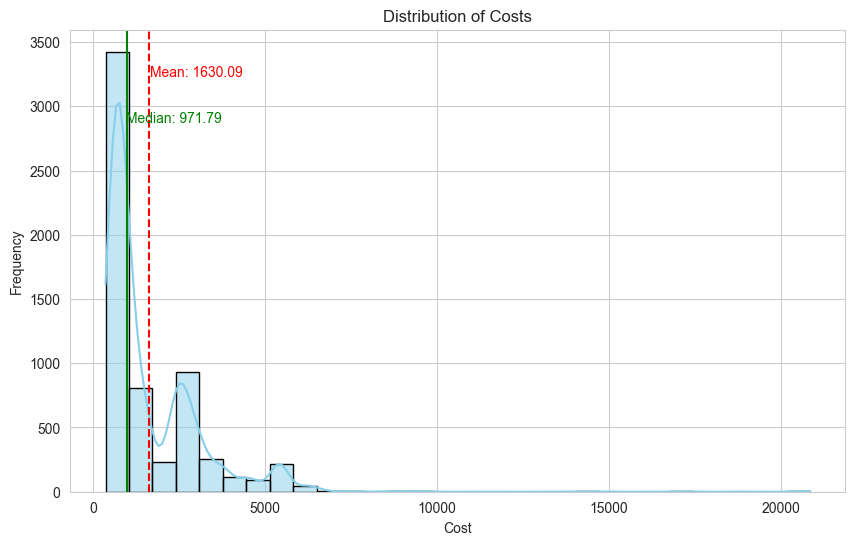

In [10]:
# setting seaborn visualisation
sns.set_style("whitegrid")

# Ploting the histogram with KDE
plt.figure(figsize=(10, 6))
sns.histplot(df['cost'], bins=30, kde=True, color='skyblue', edgecolor='black')

# Calculating mean and median
mean = df['cost'].mean()
median = df['cost'].median()

# Adding lines for mean and median
plt.axvline(mean, color='r', linestyle='--')
plt.axvline(median, color='g', linestyle='-')

# Adding annotations for mean and median
plt.text(mean+2, plt.ylim()[1]*0.9, 'Mean: {:.2f}'.format(mean), color='r')
plt.text(median-15, plt.ylim()[1]*0.8, 'Median: {:.2f}'.format(median), color='g')

# Set title and labels
plt.title('Distribution of Costs')
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.show()


### 4. Ranking Function

In [11]:
def rank_hospitals(df):
    
    """
    Ranks hospitals based on the cost for each service code.
    
    Parameters:
    - df (DataFrame): The input dataframe containing hospital data.
    
    Returns:
    - cheapest_hospitals (DataFrame): Dataframe containing the cheapest hospitals for each service code.
    - costliest_hospitals (DataFrame): Dataframe containing the costliest hospitals for each service code.
    """
    
    # Sorting the dataframe based on 'service_code' and 'cost' columns
    df_sorted = df.sort_values(by=['service_code', 'cost'])
    
    # Grouping by 'service_code' and getting the first entry for the cheapest hospital
    cheapest_hospitals = df_sorted.groupby('service_code').first()
    
    # Grouping by 'service_code' and getting the last entry for the costliest hospital
    costliest_hospitals = df_sorted.groupby('service_code').last()
    
    return cheapest_hospitals, costliest_hospitals

# Calling the rank_hospitals function to get the cheapest and costliest hospitals
cheapest, costliest = rank_hospitals(df)

# Printing the results
print("Cheapest Hospitals:\n", cheapest)
print("\n->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->")
print("\nCostliest Hospitals:\n", costliest)


Cheapest Hospitals:
              service_code_description hospital_ID     cost
service_code                                              
22818                   Covid Vaccine  27-1145142  1875.90
29850                     Hip Surgery  20-8075502   470.02
29870                    Knee surgery  20-8075502   351.22

->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->

Costliest Hospitals:
              service_code_description hospital_ID      cost
service_code                                               
22818                   Covid Vaccine  26-2045908  20843.36
29850                     Hip Surgery  26-2045908   6074.44
29870                    Knee surgery  26-2045908   5691.52


### 5. SQLite Database Operations

In [12]:
# Creating a new SQLite database
conn = sqlite3.connect('hospital_data.db')

# Loading the dataframe into the SQLite database
df.to_sql('hospital_data', conn, if_exists='replace', index=False)

# Fetching data from the database to ensure it's stored correctly
sample_data = pd.read_sql_query("SELECT * FROM hospital_data LIMIT 5", conn)
print(sample_data)


   service_code service_code_description hospital_ID     cost
0         29870             Knee surgery  1003820630  1432.34
1         29870             Knee surgery  1003820630  1016.51
2         29850              Hip Surgery  1003820630  1519.18
3         22818            Covid Vaccine  1003820630  5402.73
4         29870             Knee surgery  1013970078  1432.34


### 6. SQL Query for Mean and Standard Deviation

In [13]:
# Defining the SQL query to calculate mean and standard deviation of the cost for each service_code

query = """
WITH MeanCost AS (
    SELECT 
        `service_code`,
        AVG(`cost`) as Mean_Cost
    FROM 
        hospital_data
    GROUP BY 
        `service_code`
),


Variance AS (
    SELECT 
        h.`service_code`,
        AVG((h.`cost` - m.Mean_Cost) * (h.`cost` - m.Mean_Cost)) as Var_Cost
    FROM 
        hospital_data h
    JOIN 
        MeanCost m ON h.`service_code` = m.`service_code`
    GROUP BY 
        h.`service_code`
)


SELECT 
    m.`service_code`,
    m.Mean_Cost,
    SQRT(v.Var_Cost) as Std_Deviation
FROM 
    MeanCost m
JOIN 
    Variance v ON m.`service_code` = v.`service_code`
"""

# Executing the SQL query and storing the results in the 'results' dataframe
results = pd.read_sql_query(query, conn)

# Printing the results
print(results)


   service_code    Mean_Cost  Std_Deviation
0         22818  3402.541164    1709.510988
1         29850   965.211716     513.016666
2         29870   820.209469     468.551561


### 7. Export Results

In [14]:
# Exporting ranks to Excel
cheapest.to_excel("cheapest_hospitals.xlsx", index=False)
costliest.to_excel("costliest_hospitals.xlsx", index=False)

# Exporting statistics to Excel
results.to_excel("statistics.xlsx", index=False)


### checking the final results

In [15]:
# Reading the saved cheapest_hospitals Excel file
df1 = pd.read_excel("cheapest_hospitals.xlsx")

# Displaying the content 
df1

,service_code_description,hospital_ID,cost
0,Covid Vaccine,27-1145142,1875.90
1,Hip Surgery,20-8075502,470.02
2,Knee surgery,20-8075502,351.22


In [16]:
# Reading the saved costliest_hospital Excel file
df1 = pd.read_excel("costliest_hospitals.xlsx")

# Displaying the content 
df1

,service_code_description,hospital_ID,cost
0,Covid Vaccine,26-2045908,20843.36
1,Hip Surgery,26-2045908,6074.44
2,Knee surgery,26-2045908,5691.52


In [17]:
# Reading the saved statistics Excel file
df1 = pd.read_excel("statistics.xlsx")

# Displaying the content 
df1

,service_code,Mean_Cost,Std_Deviation
0,22818,3402.541164,1709.510988
1,29850,965.211716,513.016666
2,29870,820.209469,468.551561


##### Code by :- Rohit Pani